In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mdrifaturrahman33/levir-cd")

print("Path to dataset files:", path)

100%|██████████| 2.30G/2.30G [00:21<00:00, 113MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1


In [3]:
ls /root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/'LEVIR CD'/train/A


train_100.png  train_181.png  train_261.png  train_341.png  train_421.png
train_101.png  train_182.png  train_262.png  train_342.png  train_422.png
train_102.png  train_183.png  train_263.png  train_343.png  train_423.png
train_103.png  train_184.png  train_264.png  train_344.png  train_424.png
train_104.png  train_185.png  train_265.png  train_345.png  train_425.png
train_105.png  train_186.png  train_266.png  train_346.png  train_426.png
train_106.png  train_187.png  train_267.png  train_347.png  train_427.png
train_107.png  train_188.png  train_268.png  train_348.png  train_428.png
train_108.png  train_189.png  train_269.png  train_349.png  train_429.png
train_109.png  train_18.png   train_26.png   train_34.png   train_42.png
train_10.png   train_190.png  train_270.png  train_350.png  train_430.png
train_110.png  train_191.png  train_271.png  train_351.png  train_431.png
train_111.png  train_192.png  train_272.png  train_352.png  train_432.png
train_112.png  train_193.png  train_273

In [4]:
DATASET_PATH = "/root/.cache/kagglehub/datasets/mdrifaturrahman33/levir-cd/versions/1/LEVIR CD/"  # <------------------this
TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/label')

VAL_IMG1_DIR = os.path.join(DATASET_PATH, 'val/A')
VAL_IMG2_DIR = os.path.join(DATASET_PATH, 'val/B')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val/label')

TEST_IMG1_DIR = os.path.join(DATASET_PATH, 'test/A')
TEST_IMG2_DIR = os.path.join(DATASET_PATH, 'test/B')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test/label')

In [6]:
IMG_SIZE = 256
BATCH_SIZE = 4  # <--------------------this


In [7]:
import matplotlib.pyplot as plt

def visualize_sample_pairs(img1_dir, img2_dir, mask_dir, title):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])

    for i in range(2):
        img1 = cv2.imread(img1_files[i])
        img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
        img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

        img2 = cv2.imread(img2_files[i])
        img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

        mask = cv2.imread(mask_files[i], cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))

        plt.figure(figsize=(15, 4))
        plt.suptitle(f"{title} Sample {i+1}", fontsize=16)

        plt.subplot(1, 3, 1)
        plt.imshow(img1)
        plt.title("Image 1 (T1)")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(img2)
        plt.title("Image 2 (T2)")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.show()

visualize_sample_pairs(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR, "Train")
visualize_sample_pairs(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR, "Validation")
visualize_sample_pairs(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR, "Test")


Output hidden; open in https://colab.research.google.com to view.

In [8]:
def get_file_lists(img1_dir, img2_dir, mask_dir):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir) if f.endswith(('.tif', '.png', '.jpg'))])
    return img1_files, img2_files, mask_files

train_imgs1, train_imgs2, train_masks = get_file_lists(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR)
val_imgs1, val_imgs2, val_masks = get_file_lists(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR)
test_imgs1, test_imgs2, test_masks = get_file_lists(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR)

print(f"Train: {len(train_imgs1)} pairs")
print(f"Val  : {len(val_imgs1)} pairs")
print(f"Test : {len(test_imgs1)} pairs")


Train: 445 pairs
Val  : 64 pairs
Test : 128 pairs


In [16]:
def load_pair_numpy(img1_path, img2_path, mask_path):
    img1 = cv2.imread(img1_path.decode(), cv2.IMREAD_COLOR)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img1, (IMG_SIZE, IMG_SIZE))

    img2 = cv2.imread(img2_path.decode(), cv2.IMREAD_COLOR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img2, (IMG_SIZE, IMG_SIZE))

    img_pair = np.concatenate([img1, img2], axis=-1) / 255.0

    mask = cv2.imread(mask_path.decode(), cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, axis=-1)

    return img_pair.astype(np.float32), mask

def load_pair_tf(img1_path, img2_path, mask_path):
    img_pair, mask = tf.numpy_function(load_pair_numpy, [img1_path, img2_path, mask_path], [tf.float32, tf.float32])
    img_pair.set_shape([IMG_SIZE, IMG_SIZE, 6])
    mask.set_shape([IMG_SIZE, IMG_SIZE, 1])
    return img_pair, mask

In [17]:
def create_dataset(img1_list, img2_list, mask_list, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices((img1_list, img2_list, mask_list))
    ds = ds.map(load_pair_tf, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=100)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(train_imgs1, train_imgs2, train_masks, shuffle=True)
val_ds = create_dataset(val_imgs1, val_imgs2, val_masks)
test_ds = create_dataset(test_imgs1, test_imgs2, test_masks)


In [11]:
def fc_ef_model(input_size=(IMG_SIZE, IMG_SIZE, 6)):
    inputs = layers.Input(input_size)

    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

model = fc_ef_model()
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      3,520 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │  1,180,160 │ max_pooling2d_2[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │  2,359,808 │ conv2d_6[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 16, 16,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  4,719,616 │ max_pooling2d_3[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  9,438,208 │ conv2d_8[0][0]    │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 32, 32,    │  2,097,664 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv2d_transpose

 Total params: 31,033,473 (118.38 MB)

 Trainable params: 31,033,473 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred_bin)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred_bin) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def precision_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    predicted_positives = tf.reduce_sum(y_pred_bin)
    precision = (true_positives + smooth) / (predicted_positives + smooth)
    return precision

def recall_metric(y_true, y_pred, smooth=1e-6):
    y_pred_bin = tf.cast(y_pred > 0.5, tf.float32)
    true_positives = tf.reduce_sum(y_true * y_pred_bin)
    actual_positives = tf.reduce_sum(y_true)
    recall = (true_positives + smooth) / (actual_positives + smooth)
    return recall

def f1_metric(y_true, y_pred, smooth=1e-6):
    prec = precision_metric(y_true, y_pred, smooth)
    rec = recall_metric(y_true, y_pred, smooth)
    return 2 * (prec * rec) / (prec + rec + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)
    dl = dice_loss(y_true, y_pred)
    return bce + dl

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return 1 - dice

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=bce_dice_loss,
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        iou_metric,
        precision_metric,
        recall_metric,
        f1_metric
    ]
)

print("done")

done


Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 6))
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 6))
  warnings.warn(msg)


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - accuracy: 0.9076 - f1_metric: 0.0129 - iou_metric: 0.0069 - loss: 1.3032 - precision_metric: 0.7605 - recall_metric: 0.0452

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 6))
  warnings.warn(msg)



Epoch 1: val_f1_metric improved from -inf to 0.00000, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 121s 633ms/step - accuracy: 0.9080 - f1_metric: 0.0128 - iou_metric: 0.0069 - loss: 1.3024 - precision_metric: 0.7620 - recall_metric: 0.0448 - val_accuracy: 0.9567 - val_f1_metric: 2.8675e-10 - val_iou_metric: 1.4337e-10 - val_loss: 1.1572 - val_precision_metric: 1.0000 - val_recall_metric: 1.4337e-10 - learning_rate: 1.0000e-04
Epoch 2/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9421 - f1_metric: 0.0017 - iou_metric: 0.0011 - loss: 1.1679 - precision_metric: 0.9868 - recall_metric: 0.0011    
Epoch 2: val_f1_metric improved from 0.00000 to 0.13974, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 82s 406ms/step - accuracy: 0.9422 - f1_metric: 0.0018 - iou_metric: 0.0011 - loss: 1.1675 - precision_metric: 0.9858 - recall_metric: 0.0012 - val_accuracy: 0.9475 - val_f1_metric: 0.1397 - val_iou_metric: 0.0846 - val_loss: 1.0122 - val_precision_metric: 0.2660 - val_recall_metric: 0.1371 - learning_rate: 1.0000e-04
Epoch 3/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9269 - f1_metric: 0.1999 - iou_metric: 0.1189 - loss: 0.9626 - precision_metric: 0.2752 - recall_metric: 0.2350
Epoch 3: val_f1_metric improved from 0.13974 to 0.42428, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 53s 414ms/step - accuracy: 0.9270 - f1_metric: 0.2007 - iou_metric: 0.1194 - loss: 0.9620 - precision_metric: 0.2757 - recall_metric: 0.2361 - val_accuracy: 0.9190 - val_f1_metric: 0.4243 - val_iou_metric: 0.2735 - val_loss: 0.8176 - val_precision_metric: 0.3068 - val_recall_metric: 0.7327 - learning_rate: 1.0000e-04
Epoch 4/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9328 - f1_metric: 0.4620 - iou_metric: 0.3062 - loss: 0.7573 - precision_metric: 0.4568 - recall_metric: 0.5349
Epoch 4: val_f1_metric improved from 0.42428 to 0.50466, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 364ms/step - accuracy: 0.9330 - f1_metric: 0.4620 - iou_metric: 0.3062 - loss: 0.7570 - precision_metric: 0.4569 - recall_metric: 0.5349 - val_accuracy: 0.9460 - val_f1_metric: 0.5047 - val_iou_metric: 0.3427 - val_loss: 0.6897 - val_precision_metric: 0.4099 - val_recall_metric: 0.7020 - learning_rate: 1.0000e-04
Epoch 5/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9508 - f1_metric: 0.5418 - iou_metric: 0.3788 - loss: 0.6414 - precision_metric: 0.5529 - recall_metric: 0.5856
Epoch 5: val_f1_metric improved from 0.50466 to 0.56069, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 410ms/step - accuracy: 0.9509 - f1_metric: 0.5417 - iou_metric: 0.3787 - loss: 0.6415 - precision_metric: 0.5529 - recall_metric: 0.5854 - val_accuracy: 0.9561 - val_f1_metric: 0.5607 - val_iou_metric: 0.3941 - val_loss: 0.6082 - val_precision_metric: 0.4796 - val_recall_metric: 0.7148 - learning_rate: 1.0000e-04
Epoch 6/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9564 - f1_metric: 0.5738 - iou_metric: 0.4120 - loss: 0.5921 - precision_metric: 0.5703 - recall_metric: 0.6411
Epoch 6: val_f1_metric improved from 0.56069 to 0.59136, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 465ms/step - accuracy: 0.9564 - f1_metric: 0.5737 - iou_metric: 0.4118 - loss: 0.5922 - precision_metric: 0.5703 - recall_metric: 0.6409 - val_accuracy: 0.9671 - val_f1_metric: 0.5914 - val_iou_metric: 0.4243 - val_loss: 0.5492 - val_precision_metric: 0.6186 - val_recall_metric: 0.6005 - learning_rate: 1.0000e-04
Epoch 7/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9569 - f1_metric: 0.6157 - iou_metric: 0.4515 - loss: 0.5532 - precision_metric: 0.6169 - recall_metric: 0.6449
Epoch 7: val_f1_metric improved from 0.59136 to 0.60979, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 48s 366ms/step - accuracy: 0.9570 - f1_metric: 0.6156 - iou_metric: 0.4514 - loss: 0.5531 - precision_metric: 0.6169 - recall_metric: 0.6448 - val_accuracy: 0.9687 - val_f1_metric: 0.6098 - val_iou_metric: 0.4438 - val_loss: 0.5280 - val_precision_metric: 0.6429 - val_recall_metric: 0.6154 - learning_rate: 1.0000e-04
Epoch 8/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9575 - f1_metric: 0.6221 - iou_metric: 0.4598 - loss: 0.5430 - precision_metric: 0.6263 - recall_metric: 0.6670
Epoch 8: val_f1_metric improved from 0.60979 to 0.64022, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 411ms/step - accuracy: 0.9575 - f1_metric: 0.6219 - iou_metric: 0.4597 - loss: 0.5429 - precision_metric: 0.6263 - recall_metric: 0.6668 - val_accuracy: 0.9720 - val_f1_metric: 0.6402 - val_iou_metric: 0.4755 - val_loss: 0.4858 - val_precision_metric: 0.6875 - val_recall_metric: 0.6280 - learning_rate: 1.0000e-04
Epoch 9/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9655 - f1_metric: 0.6531 - iou_metric: 0.4925 - loss: 0.4881 - precision_metric: 0.6579 - recall_metric: 0.6728
Epoch 9: val_f1_metric improved from 0.64022 to 0.64372, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 356ms/step - accuracy: 0.9655 - f1_metric: 0.6530 - iou_metric: 0.4925 - loss: 0.4881 - precision_metric: 0.6579 - recall_metric: 0.6727 - val_accuracy: 0.9658 - val_f1_metric: 0.6437 - val_iou_metric: 0.4815 - val_loss: 0.4893 - val_precision_metric: 0.5570 - val_recall_metric: 0.7881 - learning_rate: 1.0000e-04
Epoch 10/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9639 - f1_metric: 0.6849 - iou_metric: 0.5276 - loss: 0.4567 - precision_metric: 0.6857 - recall_metric: 0.7142
Epoch 10: val_f1_metric improved from 0.64372 to 0.67645, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 412ms/step - accuracy: 0.9639 - f1_metric: 0.6847 - iou_metric: 0.5274 - loss: 0.4567 - precision_metric: 0.6857 - recall_metric: 0.7140 - val_accuracy: 0.9715 - val_f1_metric: 0.6765 - val_iou_metric: 0.5160 - val_loss: 0.4459 - val_precision_metric: 0.6272 - val_recall_metric: 0.7599 - learning_rate: 1.0000e-04
Epoch 11/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9693 - f1_metric: 0.6903 - iou_metric: 0.5367 - loss: 0.4356 - precision_metric: 0.7009 - recall_metric: 0.7085
Epoch 11: val_f1_metric improved from 0.67645 to 0.70538, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 56s 446ms/step - accuracy: 0.9693 - f1_metric: 0.6903 - iou_metric: 0.5367 - loss: 0.4356 - precision_metric: 0.7009 - recall_metric: 0.7084 - val_accuracy: 0.9765 - val_f1_metric: 0.7054 - val_iou_metric: 0.5486 - val_loss: 0.4009 - val_precision_metric: 0.7244 - val_recall_metric: 0.7027 - learning_rate: 1.0000e-04
Epoch 12/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9681 - f1_metric: 0.7080 - iou_metric: 0.5541 - loss: 0.4222 - precision_metric: 0.7115 - recall_metric: 0.7332
Epoch 12: val_f1_metric did not improve from 0.70538
112/112 ━━━━━━━━━━━━━━━━━━━━ 47s 348ms/step - accuracy: 0.9682 - f1_metric: 0.7079 - iou_metric: 0.5540 - loss: 0.4222 - precision_metric: 0.7115 - recall_metric: 0.7331 - val_accuracy: 0.9714 - val_f1_metric: 0.6875 - val_iou_metric: 0.5299 - val_loss: 0.4297 - val_precision_metric: 0.6130 - val_recall_metric: 0.8059 - learning_rate: 1.0000e-04
Epoch 13/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9

112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 414ms/step - accuracy: 0.9704 - f1_metric: 0.7223 - iou_metric: 0.5721 - loss: 0.3992 - precision_metric: 0.7294 - recall_metric: 0.7413 - val_accuracy: 0.9767 - val_f1_metric: 0.7252 - val_iou_metric: 0.5734 - val_loss: 0.3756 - val_precision_metric: 0.6858 - val_recall_metric: 0.7868 - learning_rate: 1.0000e-04
Epoch 14/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9731 - f1_metric: 0.7607 - iou_metric: 0.6167 - loss: 0.3488 - precision_metric: 0.7565 - recall_metric: 0.7765
Epoch 14: val_f1_metric improved from 0.72519 to 0.72632, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 52s 405ms/step - accuracy: 0.9731 - f1_metric: 0.7606 - iou_metric: 0.6166 - loss: 0.3489 - precision_metric: 0.7564 - recall_metric: 0.7764 - val_accuracy: 0.9782 - val_f1_metric: 0.7263 - val_iou_metric: 0.5738 - val_loss: 0.3711 - val_precision_metric: 0.7487 - val_recall_metric: 0.7195 - learning_rate: 1.0000e-04
Epoch 15/15
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9728 - f1_metric: 0.7530 - iou_metric: 0.6083 - loss: 0.3676 - precision_metric: 0.7609 - recall_metric: 0.7649
Epoch 15: val_f1_metric improved from 0.72632 to 0.74218, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 51s 400ms/step - accuracy: 0.9728 - f1_metric: 0.7529 - iou_metric: 0.6081 - loss: 0.3676 - precision_metric: 0.7608 - recall_metric: 0.7647 - val_accuracy: 0.9784 - val_f1_metric: 0.7422 - val_iou_metric: 0.5952 - val_loss: 0.3504 - val_precision_metric: 0.7112 - val_recall_metric: 0.7879 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


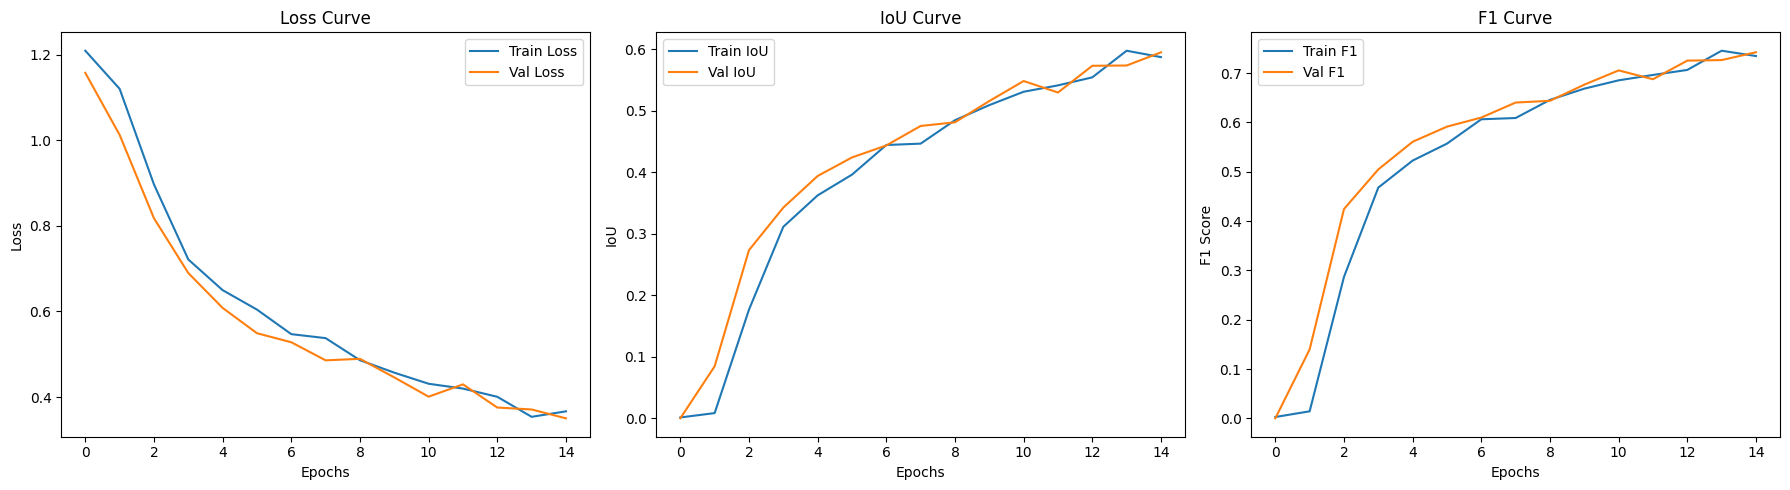

Training complete


In [20]:

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    'best_fc_ef_cd.h5',
    monitor='val_f1_metric',
    mode='max',
    save_best_only=True,
    verbose=1
)

early_stop_cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_metric',
    mode='max',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_cb = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15
    ,
    callbacks=[checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history.history['iou_metric'], label='Train IoU')
plt.plot(history.history['val_iou_metric'], label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history.history['f1_metric'], label='Train F1')
plt.plot(history.history['val_f1_metric'], label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

print("Training complete")

In [25]:
def visualize_predictions_grid(dataset, num_samples=5):
    import matplotlib.pyplot as plt
    import tensorflow as tf

    for imgs, masks in dataset.take(1):
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        num_samples_to_show = min(num_samples, tf.shape(imgs)[0])

        for i in range(num_samples_to_show):
            plt.figure(figsize=(16, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(tf.cast(imgs[i][:, :, :3], tf.float32), vmin=0, vmax=1)
            plt.title("Image 1")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(tf.cast(imgs[i][:, :, 3:6], tf.float32), vmin=0, vmax=1)
            plt.title("Image 2")
            plt.axis('off')

            # Ground Truth
            plt.subplot(1, 4, 3)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            # Predicted Mask
            plt.subplot(1, 4, 4)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_predictions_grid(test_ds, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

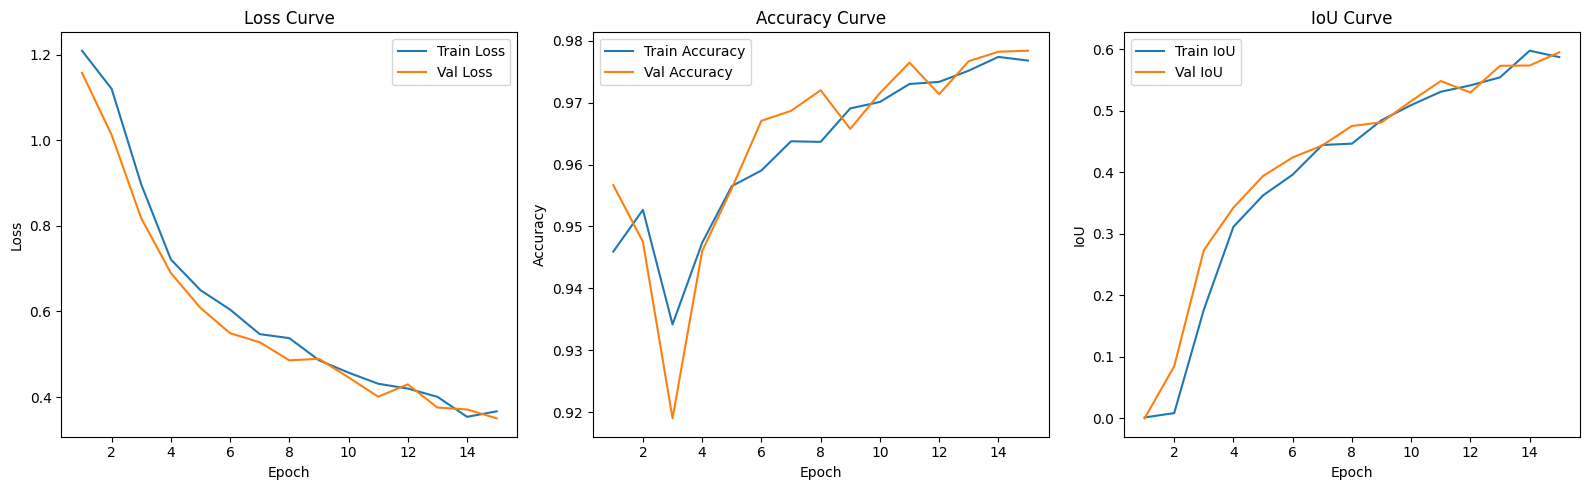

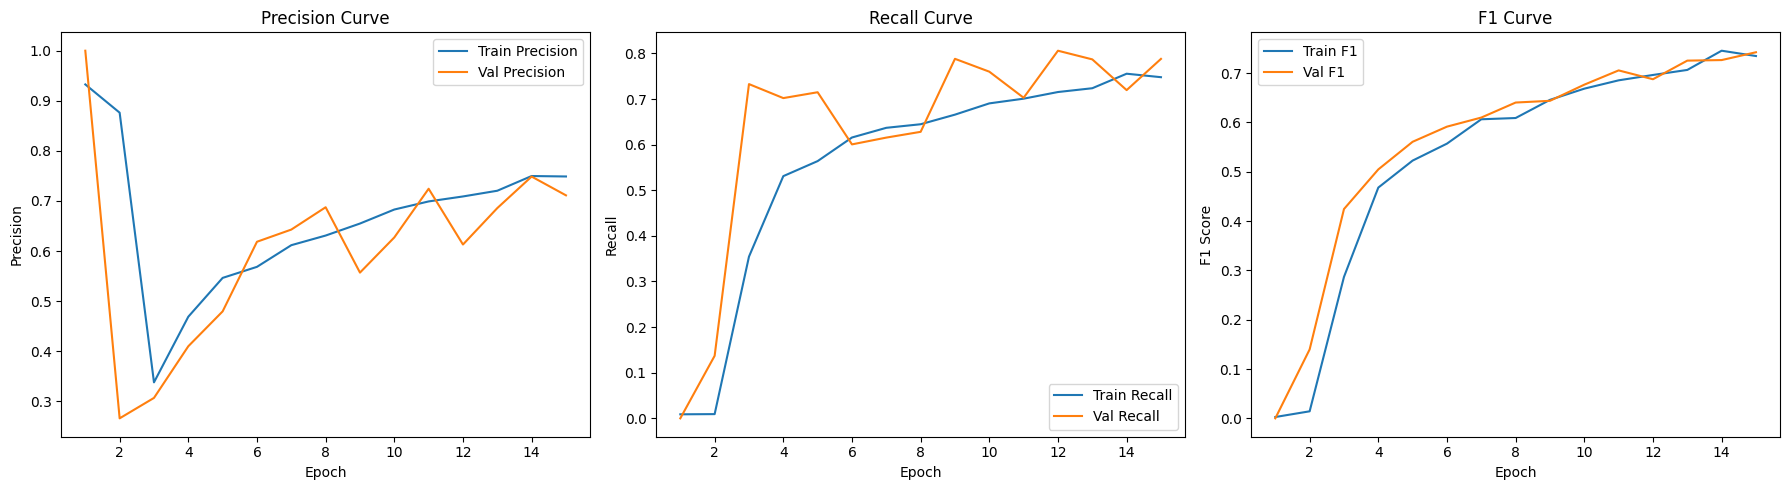

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(16, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, accuracy, label='Train Accuracy')
plt.plot(epochs, val_accuracy, label='Val Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, iou, label='Train IoU')
plt.plot(epochs, val_iou, label='Val IoU')
plt.title('IoU Curve')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, precision, label='Train Precision')
plt.plot(epochs, val_precision, label='Val Precision')
plt.title('Precision Curve')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, recall, label='Train Recall')
plt.plot(epochs, val_recall, label='Val Recall')
plt.title('Recall Curve')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, f1, label='Train F1')
plt.plot(epochs, val_f1, label='Val F1')
plt.title('F1 Curve')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


In [34]:
history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

epochs = range(1, len(loss) + 1)
print(" Final Training Metrics:")

print(f" Final Train Loss: {loss[-1]:.4f}")
print(f" Final Val Loss  : {val_loss[-1]:.4f}\n")

print(f" Final Train Accuracy: {accuracy[-1]:.4f}")
print(f" Final Val Accuracy  : {val_accuracy[-1]:.4f}\n")

print(f" Final Train IoU: {iou[-1]:.4f}")
print(f" Final Val IoU  : {val_iou[-1]:.4f}\n")

print(f" Final Train Precision: {precision[-1]:.4f}")
print(f" Final Val Precision  : {val_precision[-1]:.4f}\n")

print(f" Final Train Recall: {recall[-1]:.4f}")
print(f" Final Val Recall  : {val_recall[-1]:.4f}\n")

print(f" Final Train F1 Score: {f1[-1]:.4f}")
print(f" Final Val F1 Score  : {val_f1[-1]:.4f}")



 Final Training Metrics:
 Final Train Loss: 0.3667
 Final Val Loss  : 0.3504

 Final Train Accuracy: 0.9768
 Final Val Accuracy  : 0.9784

 Final Train IoU: 0.5875
 Final Val IoU  : 0.5952

 Final Train Precision: 0.7489
 Final Val Precision  : 0.7112

 Final Train Recall: 0.7478
 Final Val Recall  : 0.7879

 Final Train F1 Score: 0.7345
 Final Val F1 Score  : 0.7422


In [36]:
additional_epochs = 15

history_additional = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1] + additional_epochs + 1,
    initial_epoch=history.epoch[-1] + 1,
    callbacks=[ checkpoint_cb, early_stop_cb, reduce_lr_cb],
    verbose=1
)

Epoch 16/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.9755 - f1_metric: 0.7625 - iou_metric: 0.6210 - loss: 0.3400 - precision_metric: 0.7611 - recall_metric: 0.7762
Epoch 16: val_f1_metric improved from 0.74218 to 0.75654, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 49s 370ms/step - accuracy: 0.9755 - f1_metric: 0.7624 - iou_metric: 0.6209 - loss: 0.3400 - precision_metric: 0.7611 - recall_metric: 0.7761 - val_accuracy: 0.9805 - val_f1_metric: 0.7565 - val_iou_metric: 0.6121 - val_loss: 0.3303 - val_precision_metric: 0.7701 - val_recall_metric: 0.7490 - learning_rate: 1.0000e-04
Epoch 17/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - accuracy: 0.9757 - f1_metric: 0.7752 - iou_metric: 0.6363 - loss: 0.3256 - precision_metric: 0.7882 - recall_metric: 0.7729
Epoch 17: val_f1_metric improved from 0.75654 to 0.76137, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 87s 411ms/step - accuracy: 0.9757 - f1_metric: 0.7751 - iou_metric: 0.6361 - loss: 0.3256 - precision_metric: 0.7881 - recall_metric: 0.7728 - val_accuracy: 0.9806 - val_f1_metric: 0.7614 - val_iou_metric: 0.6196 - val_loss: 0.3257 - val_precision_metric: 0.7542 - val_recall_metric: 0.7802 - learning_rate: 1.0000e-04
Epoch 18/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9780 - f1_metric: 0.7860 - iou_metric: 0.6513 - loss: 0.3068 - precision_metric: 0.7909 - recall_metric: 0.7896
Epoch 18: val_f1_metric did not improve from 0.76137
112/112 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step - accuracy: 0.9780 - f1_metric: 0.7858 - iou_metric: 0.6510 - loss: 0.3069 - precision_metric: 0.7907 - recall_metric: 0.7893 - val_accuracy: 0.9809 - val_f1_metric: 0.7598 - val_iou_metric: 0.6169 - val_loss: 0.3260 - val_precision_metric: 0.7687 - val_recall_metric: 0.7592 - learning_rate: 1.0000e-04
Epoch 19/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9

112/112 ━━━━━━━━━━━━━━━━━━━━ 88s 410ms/step - accuracy: 0.9791 - f1_metric: 0.7997 - iou_metric: 0.6686 - loss: 0.2895 - precision_metric: 0.7985 - recall_metric: 0.8075 - val_accuracy: 0.9815 - val_f1_metric: 0.7672 - val_iou_metric: 0.6274 - val_loss: 0.3143 - val_precision_metric: 0.7633 - val_recall_metric: 0.7830 - learning_rate: 1.0000e-04
Epoch 20/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9783 - f1_metric: 0.7813 - iou_metric: 0.6459 - loss: 0.3102 - precision_metric: 0.7894 - recall_metric: 0.7891
Epoch 20: val_f1_metric did not improve from 0.76719
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 341ms/step - accuracy: 0.9783 - f1_metric: 0.7812 - iou_metric: 0.6458 - loss: 0.3102 - precision_metric: 0.7894 - recall_metric: 0.7890 - val_accuracy: 0.9808 - val_f1_metric: 0.7437 - val_iou_metric: 0.5984 - val_loss: 0.3453 - val_precision_metric: 0.8079 - val_recall_metric: 0.6979 - learning_rate: 1.0000e-04
Epoch 21/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9

112/112 ━━━━━━━━━━━━━━━━━━━━ 92s 415ms/step - accuracy: 0.9786 - f1_metric: 0.7868 - iou_metric: 0.6561 - loss: 0.3030 - precision_metric: 0.7931 - recall_metric: 0.7919 - val_accuracy: 0.9815 - val_f1_metric: 0.7784 - val_iou_metric: 0.6418 - val_loss: 0.3026 - val_precision_metric: 0.7436 - val_recall_metric: 0.8250 - learning_rate: 1.0000e-04
Epoch 22/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.9798 - f1_metric: 0.8054 - iou_metric: 0.6807 - loss: 0.2788 - precision_metric: 0.8122 - recall_metric: 0.8096
Epoch 22: val_f1_metric did not improve from 0.77838
112/112 ━━━━━━━━━━━━━━━━━━━━ 46s 354ms/step - accuracy: 0.9798 - f1_metric: 0.8053 - iou_metric: 0.6806 - loss: 0.2788 - precision_metric: 0.8122 - recall_metric: 0.8095 - val_accuracy: 0.9817 - val_f1_metric: 0.7684 - val_iou_metric: 0.6301 - val_loss: 0.3128 - val_precision_metric: 0.7623 - val_recall_metric: 0.7869 - learning_rate: 1.0000e-04
Epoch 23/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9

112/112 ━━━━━━━━━━━━━━━━━━━━ 89s 410ms/step - accuracy: 0.9776 - f1_metric: 0.7668 - iou_metric: 0.6272 - loss: 0.3294 - precision_metric: 0.7698 - recall_metric: 0.7753 - val_accuracy: 0.9825 - val_f1_metric: 0.7814 - val_iou_metric: 0.6467 - val_loss: 0.2963 - val_precision_metric: 0.7663 - val_recall_metric: 0.8071 - learning_rate: 1.0000e-04
Epoch 24/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9807 - f1_metric: 0.8180 - iou_metric: 0.6944 - loss: 0.2636 - precision_metric: 0.8225 - recall_metric: 0.8208
Epoch 24: val_f1_metric did not improve from 0.78137
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 340ms/step - accuracy: 0.9808 - f1_metric: 0.8179 - iou_metric: 0.6943 - loss: 0.2636 - precision_metric: 0.8224 - recall_metric: 0.8207 - val_accuracy: 0.9817 - val_f1_metric: 0.7737 - val_iou_metric: 0.6364 - val_loss: 0.3079 - val_precision_metric: 0.7590 - val_recall_metric: 0.8002 - learning_rate: 1.0000e-04
Epoch 25/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9

112/112 ━━━━━━━━━━━━━━━━━━━━ 92s 421ms/step - accuracy: 0.9816 - f1_metric: 0.8204 - iou_metric: 0.6997 - loss: 0.2576 - precision_metric: 0.8242 - recall_metric: 0.8215 - val_accuracy: 0.9829 - val_f1_metric: 0.7859 - val_iou_metric: 0.6528 - val_loss: 0.2902 - val_precision_metric: 0.7819 - val_recall_metric: 0.8018 - learning_rate: 1.0000e-04
Epoch 26/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9818 - f1_metric: 0.8258 - iou_metric: 0.7064 - loss: 0.2511 - precision_metric: 0.8329 - recall_metric: 0.8239
Epoch 26: val_f1_metric improved from 0.78592 to 0.79397, saving model to best_fc_ef_cd.h5


112/112 ━━━━━━━━━━━━━━━━━━━━ 53s 413ms/step - accuracy: 0.9818 - f1_metric: 0.8258 - iou_metric: 0.7063 - loss: 0.2512 - precision_metric: 0.8328 - recall_metric: 0.8238 - val_accuracy: 0.9838 - val_f1_metric: 0.7940 - val_iou_metric: 0.6631 - val_loss: 0.2809 - val_precision_metric: 0.8183 - val_recall_metric: 0.7783 - learning_rate: 1.0000e-04
Epoch 27/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9818 - f1_metric: 0.8266 - iou_metric: 0.7071 - loss: 0.2515 - precision_metric: 0.8350 - recall_metric: 0.8231
Epoch 27: val_f1_metric did not improve from 0.79397
112/112 ━━━━━━━━━━━━━━━━━━━━ 45s 343ms/step - accuracy: 0.9818 - f1_metric: 0.8264 - iou_metric: 0.7069 - loss: 0.2517 - precision_metric: 0.8349 - recall_metric: 0.8229 - val_accuracy: 0.9816 - val_f1_metric: 0.7706 - val_iou_metric: 0.6318 - val_loss: 0.3115 - val_precision_metric: 0.7603 - val_recall_metric: 0.7961 - learning_rate: 1.0000e-04
Epoch 28/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.9

In [47]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_test_predictions(dataset, num_samples=5):
    for imgs, masks in dataset.take(1):
        preds = model.predict(imgs)
        preds_bin = preds > 0.5

        batch_size_actual = imgs.shape[0]
        for i in range(min(num_samples, batch_size_actual)):
            plt.figure(figsize=(16, 4))

            plt.subplot(1, 4, 1)
            plt.imshow(imgs[i][:, :, :3])
            plt.title("Image 1")
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(imgs[i][:, :, 3:6])
            plt.title("Image 2")
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(masks[i, :, :, 0], cmap='gray')
            plt.title("Ground Truth")
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(preds_bin[i, :, :, 0], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.show()

visualize_test_predictions(test_ds, num_samples=5)

# Refresh history_dict to get updated, extended history
history_dict = history.history

loss = history_dict.get('loss', [])
val_loss = history_dict.get('val_loss', [])

accuracy = history_dict.get('accuracy', [])
val_accuracy = history_dict.get('val_accuracy', [])

iou = history_dict.get('iou_metric', [])
val_iou = history_dict.get('val_iou_metric', [])

precision = history_dict.get('precision_metric', [])
val_precision = history_dict.get('val_precision_metric', [])

recall = history_dict.get('recall_metric', [])
val_recall = history_dict.get('val_recall_metric', [])

f1 = history_dict.get('f1_metric', [])
val_f1 = history_dict.get('val_f1_metric', [])

print(" Updated Final Training Metrics After Continued Training:")

print(f"🔹 Final Train Loss: {loss[-1]:.4f}")
print(f"🔹 Final Val Loss  : {val_loss[-1]:.4f}\n")

print(f"🔹 Final Train Accuracy: {accuracy[-1]:.4f}")
print(f"🔹 Final Val Accuracy  : {val_accuracy[-1]:.4f}\n")

print(f"🔹 Final Train IoU: {iou[-1]:.4f}")
print(f"🔹 Final Val IoU  : {val_iou[-1]:.4f}\n")

print(f"🔹 Final Train Precision: {precision[-1]:.4f}")
print(f"🔹 Final Val Precision  : {val_precision[-1]:.4f}\n")

print(f"🔹 Final Train Recall: {recall[-1]:.4f}")
print(f"🔹 Final Val Recall  : {val_recall[-1]:.4f}\n")

print(f"🔹 Final Train F1 Score: {f1[-1]:.4f}")
print(f"🔹 Final Val F1 Score  : {val_f1[-1]:.4f}")




Output hidden; open in https://colab.research.google.com to view.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_intermediate_features(model, dataset, num_channels_per_row=8):
    # Get one sample
    for (img1_batch, img2_batch), mask_batch in dataset.take(1):
        img1 = img1_batch[0:1]  # [1,H,W,3]
        img2 = img2_batch[0:1]  # [1,H,W,3]
        break

    # Create a new model to output all intermediate layers
    layer_outputs = [layer.output for layer in model.layers if 'conv' in layer.name or 'input' in layer.name or 'output' in layer.name]
    activation_model = tf.keras.models.Model(inputs=model.inputs, outputs=layer_outputs)

    # Get activations
    activations = activation_model.predict([img1, img2])

    # Plot Image 1 and Image 2
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1[0])
    plt.title("Image 1")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2[0])
    plt.title("Image 2")
    plt.axis('off')
    plt.show()

    # Loop over each activation to visualize
    for layer_activation, layer in zip(activations, activation_model.layers):
        if len(layer_activation.shape) == 4:  # Only for feature maps
            n_features = layer_activation.shape[-1]
            size = layer_activation.shape[1]

            n_cols = num_channels_per_row  # Features per row
            n_rows = np.ceil(n_features / n_cols).astype(int)

            display_grid = np.zeros((size * n_rows, size * n_cols))

            for col in range(n_cols):
                for row in range(n_rows):
                    channel_index = col + n_cols * row
                    if channel_index < n_features:
                        channel_image = layer_activation[0, :, :, channel_index]
                        channel_image -= channel_image.mean()
                        channel_image /= (channel_image.std() + 1e-6)
                        channel_image *= 64
                        channel_image += 128
                        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                        display_grid[
                            row * size : (row + 1) * size,
                            col * size : (col + 1) * size
                        ] = channel_image

            scale = 1. / size
            plt.figure(figsize=(scale * display_grid.shape[1], scale * display_grid.shape[0]))
            plt.title(f"{layer.name} - {n_features} channels")
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.axis('off')
            plt.show()

visualize_intermediate_features(model, test_ds, num_channels_per_row=8)


NameError: name 'model' is not defined